In [111]:
#librerias base
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import os,glob
import cv2
from sklearn import preprocessing

#keras - tensorflow
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten

In [2]:
#Carga de datos
X_train=[]
y_train=[]
os.chdir('C:/Users/Juan Carlos/Desktop/MaestriaDS/Tercer Trimestre/SL2/Proyecto/Parte2/train')
for i in os.listdir():
      img = cv2.imread(i)   
      img = cv2.resize(img,(128,128))
      X_train.append(img)
      y_train.append(i[-6:-4]) 

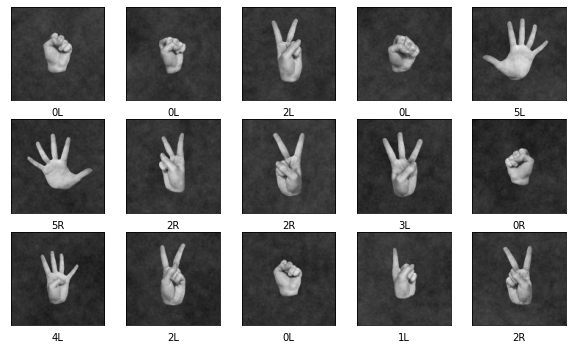

In [3]:
#Exploración de datos
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap='gray')
    plt.xlabel(y_train[i])
plt.show()

In [4]:
#Carga de datos de prueba
X_test=[]
y_test=[]
os.chdir('C:/Users/Juan Carlos/Desktop/MaestriaDS/Tercer Trimestre/SL2/Proyecto/Parte2/test')
for i in os.listdir():
      img = cv2.imread(i)   
      img = cv2.resize(img,(128,128))
      X_test.append(img)
      y_test.append(i[-6:-4])

In [5]:
os.chdir('C:/Users/Juan Carlos/Desktop/MaestriaDS/Tercer Trimestre/SL2/Proyecto/Parte2')

In [6]:
#Codificación de etiquetas 
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train_label = to_categorical(y_train, num_classes=12)
y_test_label = to_categorical(y_test, num_classes=12)

In [7]:
y_train = np.array(y_train)
X_train = np.array(X_train)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [8]:
def bitacora(confString, stadistics):
  dfdic = pd.DataFrame(stadistics,index=[0])
  dfdic.insert(loc=0,column='configString', value=confString)
  with open("./Bitacora.csv", 'a') as f:
    dfdic.to_csv(f, mode='a', header=False)
    
def SummaryString(model):
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    return short_model_summary

## Modelo

In [9]:
cnn = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), input_shape=(128,128,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(12,activation='softmax')
])

In [13]:
#Compilación de modelo
cnn.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics = ['accuracy'])

In [14]:
#Creación de checkpoint
filepath="./Parte2.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
#Entrenamiento
cnn.fit(X_train, y_train_label, epochs=3, validation_steps=800, steps_per_epoch=20, callbacks=callbacks_list)

Epoch 1/3
20/20 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9996 
Epoch 1: accuracy improved from -inf to 0.99961, saving model to .\Parte2.weights.best.hdf5
20/20 [==============================] - 376s 19s/step - loss: 0.0051 - accuracy: 0.9996
Epoch 2/3
20/20 [==============================] - ETA: 0s - loss: 4.4864e-04 - accuracy: 1.0000 
Epoch 2: accuracy improved from 0.99961 to 1.00000, saving model to .\Parte2.weights.best.hdf5
20/20 [==============================] - 370s 18s/step - loss: 4.4864e-04 - accuracy: 1.0000
Epoch 3/3
20/20 [==============================] - ETA: 0s - loss: 1.8897e-04 - accuracy: 1.0000 
Epoch 3: accuracy did not improve from 1.00000
20/20 [==============================] - 365s 18s/step - loss: 1.8897e-04 - accuracy: 1.0000


In [16]:
#Metricas
res_dict_tree = defaultdict(lambda: "Not present")
test_loss, test_acc = cnn.evaluate(X_test, y_test_label)
res_dict_tree["Accuracy_test"] = test_acc
res_dict_tree["Test_loss"] = test_loss
ss = SummaryString(cnn)
bitacora(ss,res_dict_tree)

113/113 [==============================] - 13s 115ms/step - loss: 0.0036 - accuracy: 0.9986


In [94]:
#Visualización de filtros
for layer in cnn.layers:
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d (3, 3, 3, 64)
conv2d_1 (3, 3, 64, 32)


In [113]:
for i in range(len(cnn.layers)):
    layer = cnn.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)
    
model = Model(inputs=cnn.inputs , outputs=cnn.layers[1].output)
features = model.predict(X_test[0].reshape(1,128,128,3))

0 conv2d (None, 126, 126, 64)
3 conv2d_1 (None, 61, 61, 32)
1/1 [==============================] - 0s 52ms/step


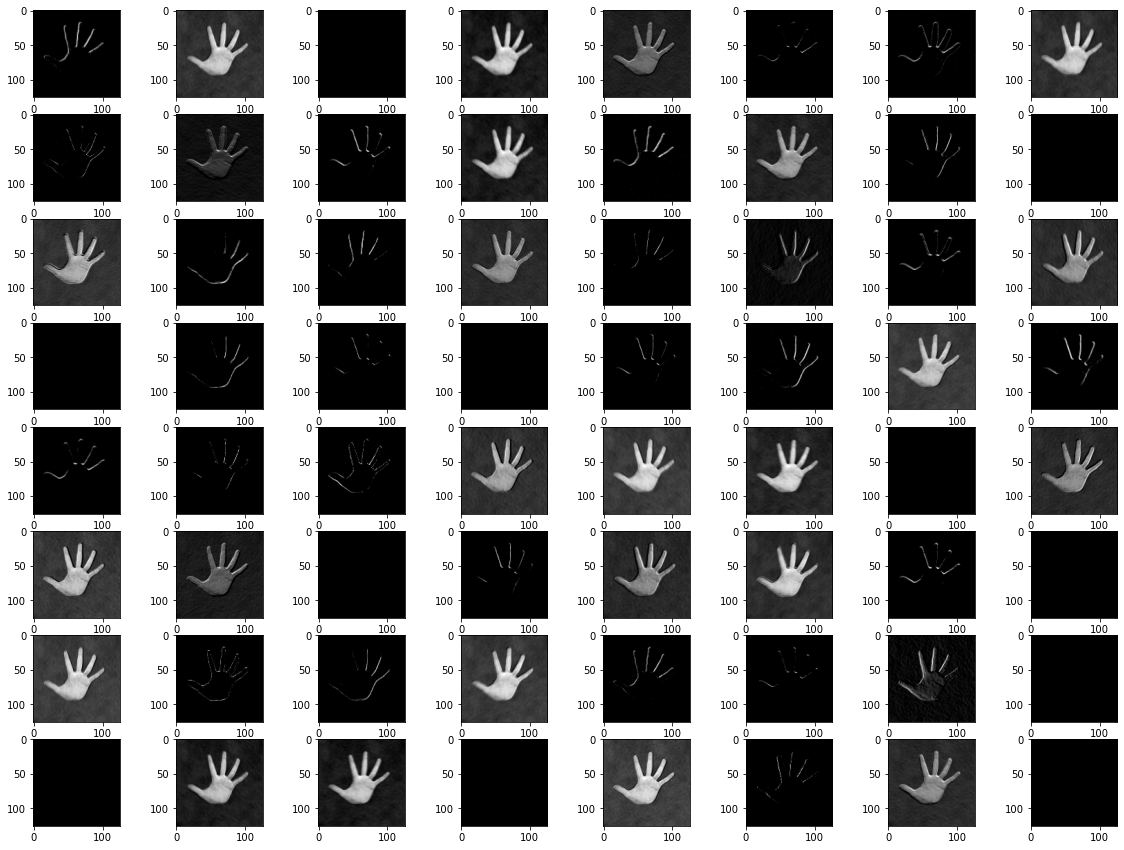

In [117]:
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

# Conclusiones

Luego de realizar distintos experimentos, adjuntos en archivo Bitacora.csv, se establecio una red neural convulucional con 2 capas convulucionales y una capa sin convolución se utilizo la función de activación ReLU.

Adjunto diagrama final de modelo.


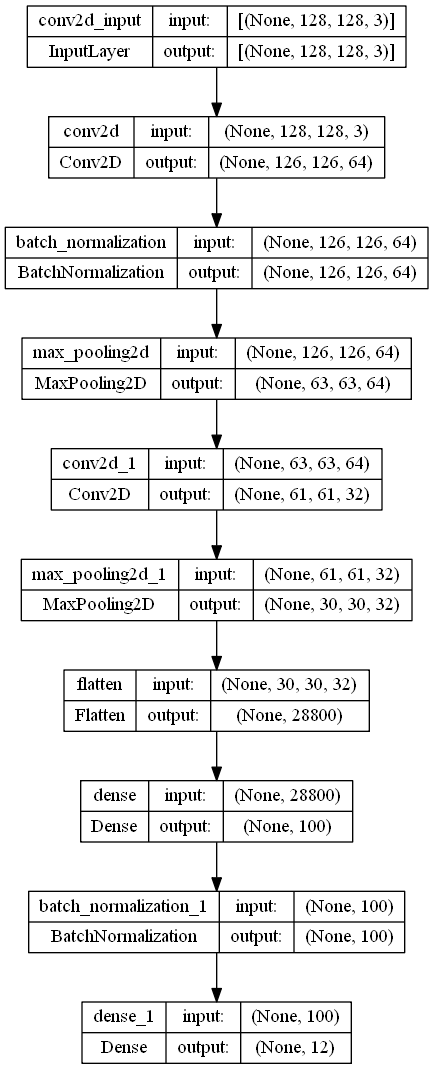

In [17]:
plot_model(cnn, to_file='Parte2.png', show_shapes=True, show_layer_names=True)

# Publicación
El proceso de publicación de la red entrenada a produción se puede realizar guardando los pesos de la red en un archivo ***HDF5***, formato utilizado por Keras.

Para realizar un despliegue por ejemplo a una página web, se puede usar un framework muy liviando de frontend para utlizar python como backend, según la investigación realizada ***Flask*** es la herramienta utilizada generalmente.